In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, mean_absolute_error, roc_auc_score, \
roc_curve, auc, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from get_metrics import get_metrics_classification

RAND = 10

Дан датасет людей, которые находились на борту Титаника.

**Описание:**

- Survived -  выжил/не выжил
- pclass - класс билета (первый, второй, третий)
- sex - пол
- Age - возраст в годах
- sibsp	- братя и сестеры / супруги на борту "Титаника" (кол-во)
- parch	- родителей / детей на борту "Титаника" (кол-во)
- ticket - номер билета
- fare - Стоимость проезда (доллары)
- cabin	- номер кабины
- embarked - порт посадки C = Шербур, Q = Квинстаун, S = Саутгемптон

Необходимо построить модель классификации, которая бы предсказывала выживет человек или нет (Survived)

# Загрузка и первичный анализ данных

1) Прочитать файл train.csv и записать в переменную df

In [90]:
df = pd.read_csv("train.csv")
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


2) В датасете мы имеем признаки с уникальным ID пассажира и номерами билета, их необходимо исключить

In [91]:
df = df.drop(['PassengerId', 'Ticket'], axis=1)
df[:5]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


# EDA анализ

4) Вывести общую информацию о датасете при помощи метода info(), а также основные описательные статистики для числовых и категориальных признаков

Какой средний возраст пассажиров? Откуда большая часть людей садилась в лайнер (порт)?

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [93]:
df.shape

(891, 10)

In [94]:
df.isna().sum()/df.shape[0] * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [95]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [96]:
df.describe(include=object)

,Name,Sex,Cabin,Embarked
count,891,891,204,889
unique,891,2,147,3
top,"Braund, Mr. Owen Harris",male,B96 B98,S
freq,1,577,4,644


Средний возраст людей - 29-30 лет, большая часть пассажиров садилась в порту Саутгемптона

5) Постройте график соотношения кол-ва выживших и тех кто не выжил - Survived в %, обязательно над графиками указать проценты (пример в ноутбуке EDA). Есть ли дисбаланс классов?

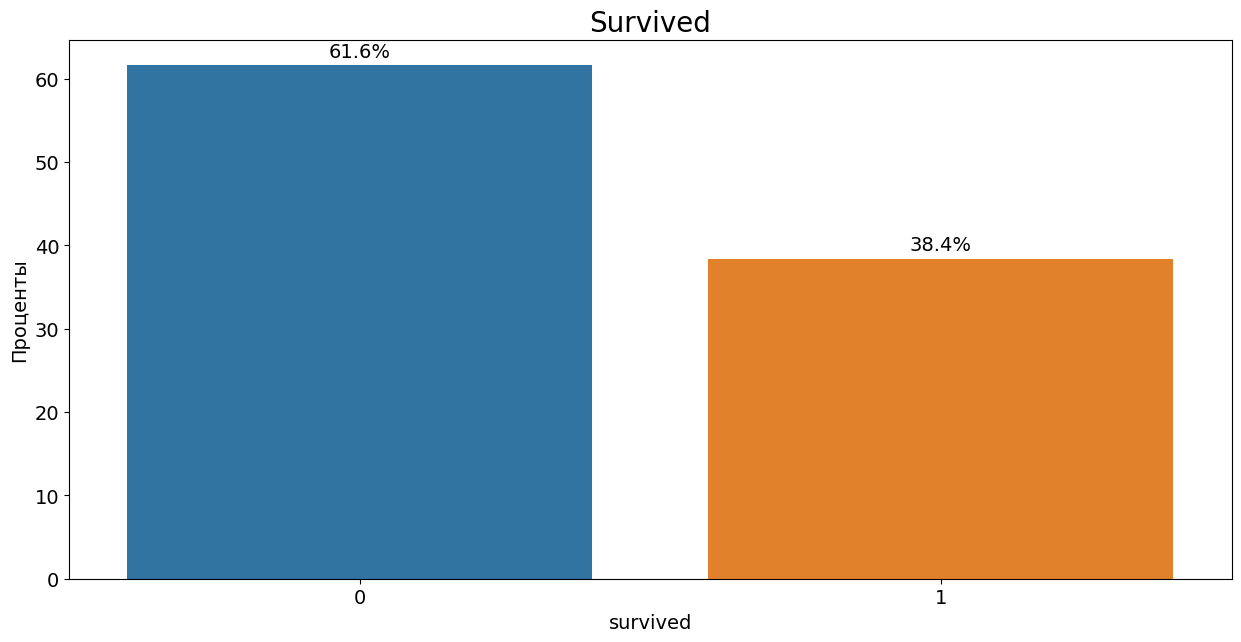

In [97]:
norm_target = (df
               .Survived
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                # координата xy
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                # центрирование
                ha='center', 
                va='center',
                xytext=(0, 10),
                # точка смещения относительно координаты
                textcoords='offset points', 
                fontsize=14)

plt.title('Survived', fontsize=20)
plt.xlabel('survived', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

## Pclass

In [98]:
def barplot_group(col_main: str, col_group: str, title: str) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage",
                     hue=col_group, data=data, palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

6) Отобразите на графике долю пассажиров в % (ось OY), которые выжили/не выжили Survived (ось OX) в каждом из классов Pclass (hue).

- Данные должны быть **нормированы** на  кол-во людей в каждом из сегментов, **пример был в ноутбке по EDA анализу**.

- Не забудьте указать цифры (%) на графике для каждого бара, как это делалось ранее. 

Например, если в группе всего 120 людей, мужчин 20, а женщин 100, то тогда мужчин - 16,7%, женщин 83,3%

**Какие выводы вы можете сделать? напишите кратко**

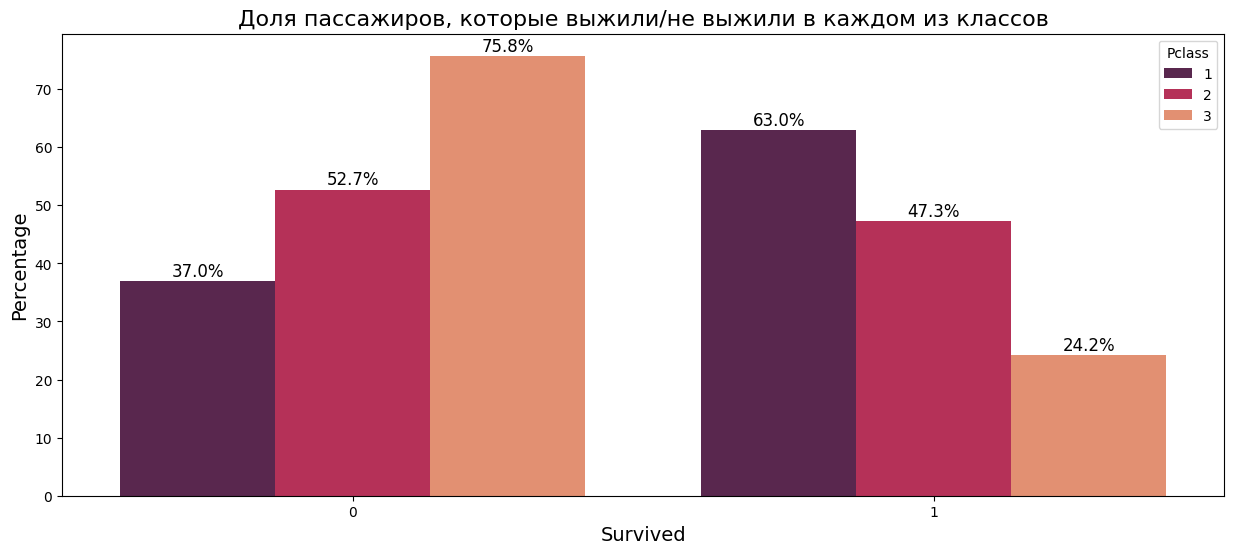

In [99]:
barplot_group('Survived', 'Pclass', "Доля пассажиров, которые выжили/не выжили в каждом из классов")

Процент выживших находится в обратно пропорциональной зависимости от класса билета

## Age

7) Отобразите график **распределения возраста Age (seaborn.displot) в разрезе Survived**. Не забывайте про common_norm=False. 

**Какие выводы вы можете сделать? напишите кратко**

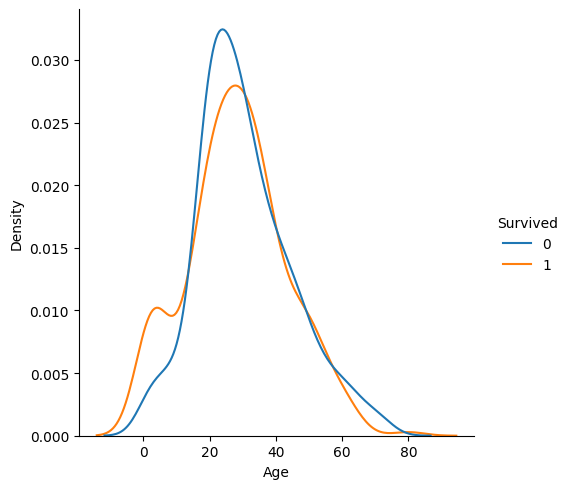

In [100]:
sns.displot(data=df, x='Age', hue='Survived', common_norm=False, kind="kde")

Среди выживших больший процент детей и меньший процент людей 20-30 лет

8) Изучите признаки **Survived, Age и Sex** при помощи sns.violinplot. Какие интересные особенности можно отметить?

По оси OX - Sex, по OY - Age, hue-Survived

<AxesSubplot: xlabel='Sex', ylabel='Age'>

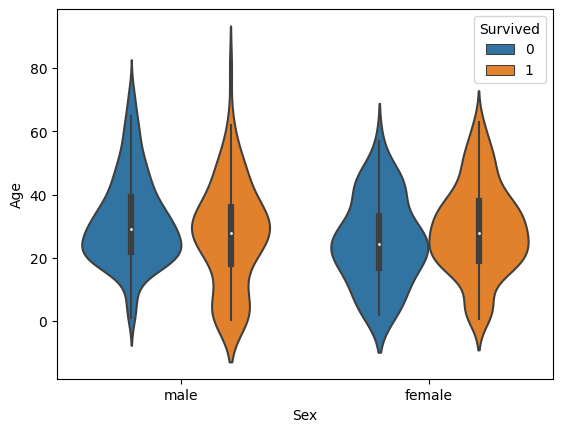

In [101]:
sns.violinplot(data=df, x='Sex', y='Age', hue='Survived')

У женщин практически нет корреляции между возрастом и процентом выживших. У мужчин наблюдается больший процент выживших среди детей и меньший процент среди людей 20-30 лет.

9) Заполните пропуски в признаке возраст Age значением -99.

**По какой причине мы берем такое значение, если хотим использовать модель дерева решений?**

In [102]:
df['Age'].fillna(-99, inplace=True)

In [103]:
df.isna().sum()/df.shape[0]

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.000000
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

## Embarked

10) Отобразите на графике долю пассажиров в % (ось OY) в разных классах Pclass (ось OX) в зависимости от того, в каком порту они садились в Титаник Embarked (hue).

- Данные должны быть **нормированы** на  кол-во людей в каждом из сегментов, **пример был в ноутбке по EDA анализу**.

- Не забудьте указать цифры (%) на графике для каждого бара, как это делалось ранее. 

Например, если в группе всего 120 людей, мужчин 20, а женщин 100, то тогда мужчин - 16,7%, женщин 83,3%

**Какие выводы вы можете сделать? напишите кратко**

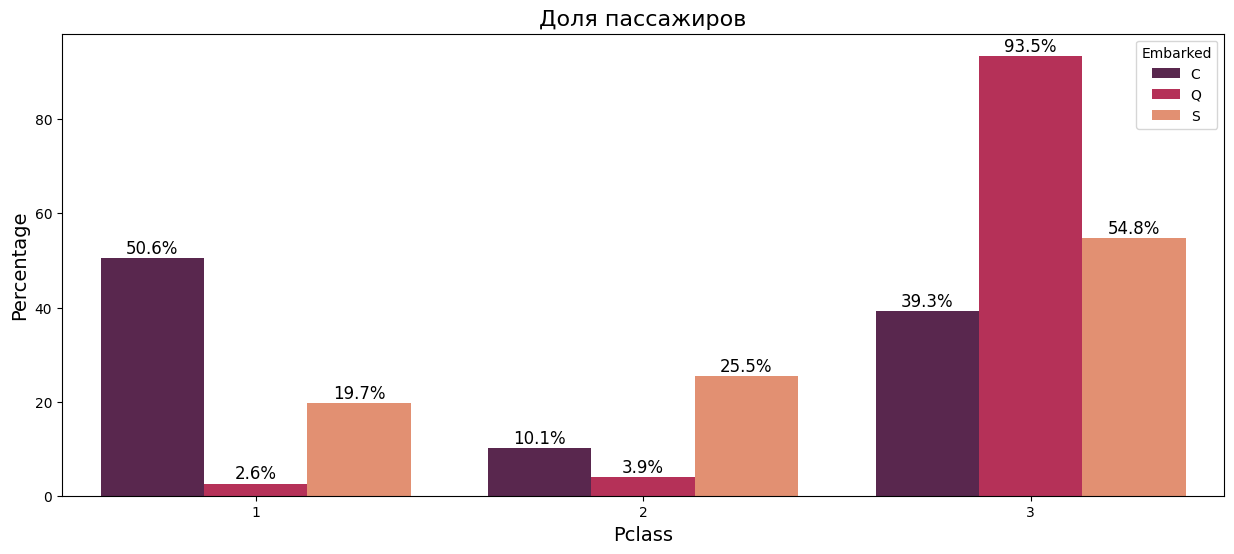

In [104]:
barplot_group('Pclass', 'Embarked', 'Доля пассажиров')

Большая часть пассажиров с билетом 1-ого класса садилась в Шербуре, В Квинстауне, наоборот, практически все билеты 3-го класса

11) Заполните пропуски в признаке Embarked при помощи группировки по Pclass модой (**было похожее задание в ДЗ по многоклассовой классификации**).

In [105]:
df.Embarked.fillna(df.groupby(['Pclass'])['Embarked'].transform(
    lambda x: x.mode()[0]), inplace=True)

In [106]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      0
dtype: int64

12) Отобразите на графике долю пассажиров в % (ось OY), которые выжили/не выжили Survived (ось OX) в зависимости от того, в каком порту они садились в Титаник Embarked (hue).

- Данные должны быть **нормированы** на  кол-во людей в каждом из сегментов, **пример был в ноутбке по EDA анализу**.

- Не забудьте указать цифры (%) на графике для каждого бара, как это делалось ранее. 

Например, если в группе всего 120 людей, мужчин 20, а женщин 100, то тогда мужчин - 16,7%, женщин 83,3%

**Какие выводы вы можете сделать? напишите кратко**

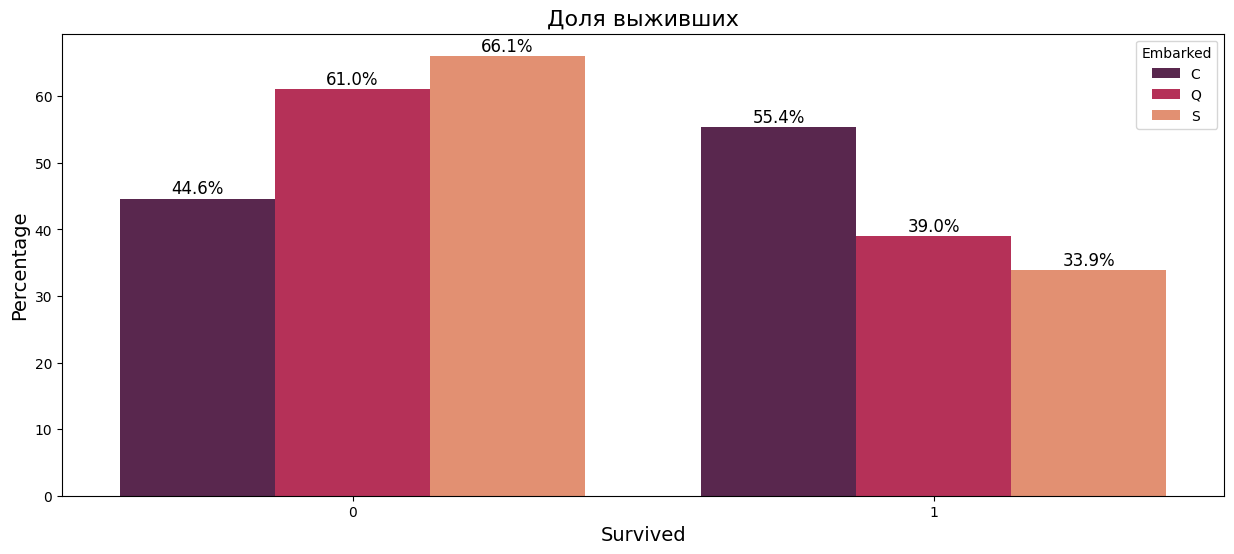

In [107]:
barplot_group('Survived', 'Embarked', "Доля выживших")

В Шербуре больше всего выживших, в Саутгемптоне меньше всего выживших

## Fare

13) Отобразите график **распределения цены билета Fare (seaborn.displot) в разрезе Survived**. Не забывайте про common_norm=False. 

**Какие выводы вы можете сделать? напишите кратко**

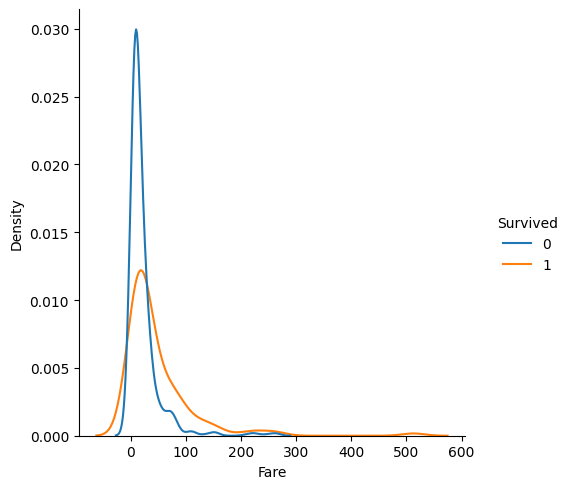

In [108]:
sns.displot(data=df, x='Fare', hue='Survived', kind='kde', common_norm=False)

Процент выживших с дорогим билетом (~80 и больше) значительно выше, чем с дешевым 

14) Проанализируйте признаки **Survived, Fare и Sex** при помощи sns.boxplot. Какие интересные особенности можно отметить? 

По оси OX - Sex, по OY - Fare, hue - Survived

<AxesSubplot: xlabel='Sex', ylabel='Fare'>

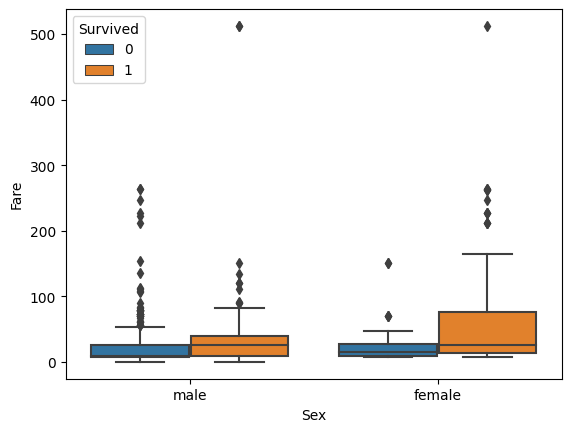

In [109]:
sns.boxplot(data=df, x='Sex', y='Fare', hue='Survived')

Средний показатель цены у выживших пассажиров выше чем у не выживших.

# Feature engineering

15) Генерация признаков

- Посмотрите подробнее на значения признака **Name**
- Создайте новый признак Title при помощи приведенного ниже регулярного выражения, которое выбирает только слова с точкой (код уже дан, просто запустить)
- Далее посчитайте самостоятельно **кол-во каждого уникального значения в Title**

In [110]:
df.Name.unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [111]:
df['Title'] = df.Name.str.extract('(\w+\.)', expand=False)
df['Title'] = df.Title.apply(lambda x: x.split('.')[0])

In [112]:
df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [113]:
len(df[df['Title']=='Mrs'])

125

In [114]:
number_title = pd.DataFrame(index=df.Title.unique(), data=[
                            len(df[df.Title == x]) for x in df.Title.unique()])

In [115]:
number_title

,0
Mr,517
Mrs,125
Miss,182
Master,40
Don,1
Rev,6
Dr,7
Mme,1
Ms,1
Major,2


16) Произведите замену в признаке Title **на значение 'Rare'** следующие значения: 

```python
'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Col','Major', 'Mlle', 'Rev', 'Dr'
```

In [116]:
rare_titles = ['Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme',
                'Don', 'Jonkheer', 'Col', 'Major', 'Mlle', 'Rev', 'Dr']

df.Title.replace(rare_titles, 'Rare', inplace=True)
df.Title

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886    Rare
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

17) Добавьте признак **FamilySize**, который говорит о кол-ве человек в семье на борту с учетом самого пассажира, используйте 

```python
SibSp + Parch + 1
```

In [117]:
df['FamilySize'] = df.SibSp + df.Parch + 1

In [118]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Mr,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,Mrs,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Miss,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,Mrs,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Mr,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,NaN,S,Rare,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B42,S,Miss,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-99.0,1,2,23.4500,NaN,S,Miss,4
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C148,C,Mr,1


18) Добавьте признак **IsAlone**, который означает, что у человека нет родственников на борту.
Если человек без родственников, то IsAlone=1, иначе IsAlone=0

In [119]:
df['IsAlone'] = df.FamilySize.transform(
    lambda x: int(x==1))
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,Mr,2,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,Mrs,2,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,Miss,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,Mrs,2,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,Mr,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,NaN,S,Rare,1,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B42,S,Miss,1,1
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-99.0,1,2,23.4500,NaN,S,Miss,4,0
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C148,C,Mr,1,1


19) Удалите лишние колонки:

- Name - так как много уникальных значений
- Cabin - так как плохо заполнено и часть из заполненных - уникальные значения

In [120]:
df = df.drop(columns=['Name', 'Cabin'])

20) Убедитесь, что пропусков в датасете нет. Если они есть, то какой то пункт пропустили

In [121]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
FamilySize    0
IsAlone       0
dtype: int64

21) Преобразуйте категориальные данные в бинарные при помощи pd.get_dummies(), числовые должны быть в том же видите. Запишите результат в новую переменную **df_label**

In [122]:
df_label = pd.get_dummies(df, drop_first=True)
df_label

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,22.0,1,0,7.2500,2,0,1,0,1,0,1,0,0
1,1,1,38.0,1,0,71.2833,2,0,0,0,0,0,0,1,0
2,1,3,26.0,0,0,7.9250,1,1,0,0,1,1,0,0,0
3,1,1,35.0,1,0,53.1000,2,0,0,0,1,0,0,1,0
4,0,3,35.0,0,0,8.0500,1,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,1,1,1,0,1,0,0,0,1
887,1,1,19.0,0,0,30.0000,1,1,0,0,1,1,0,0,0
888,0,3,-99.0,1,2,23.4500,4,0,0,0,1,1,0,0,0
889,1,1,26.0,0,0,30.0000,1,1,1,0,0,0,1,0,0


# Baseline DecisionTreeClassifier

22) Разделите выборку на train и test данные. Используйте стратификацию stratify, test_size=0.2, а также фиксацию random_state

In [123]:
x = df_label.drop(['Survived'], axis=1)
y = df_label['Survived']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=RAND)

23) Обучите **бейзлайн DecisionTreeClassifier**. При обучении обязательно зафиксируйте random_state

In [124]:
model = DecisionTreeClassifier(random_state=RAND)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=10)

24) Какие результаты по основным метрикам вы получили на test? Что можно сказать про модель?

Запишите результат в **переменную metrics**, используя функцию как в лекции

Может ли она разделять классы?

In [125]:
y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

metrics = get_metrics_classification(y_test, y_pred, y_score, 'Tree_baseline')

In [126]:
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Tree_baseline,0.77095,0.75303,0.71875,0.666667,0.691729,7.544587


25) Проверьте, не переобучилась ли модель?

In [127]:
y_pred = model.predict(x_train)
y_score = model.predict_proba(x_train)

metrics = metrics.append(get_metrics_classification(y_train, y_pred, y_score, 'Tree_baseline_train'))

/tmp/ipykernel_8641/1232052415.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(get_metrics_classification(y_train, y_pred, y_score, 'Tree_baseline_train'))


In [128]:
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Tree_baseline,0.770950,0.753030,0.718750,0.666667,0.691729,7.544587
0,Tree_baseline_train,0.983146,0.999312,0.996198,0.959707,0.977612,0.029448


Модель переобучена, разница в метриках на train и на test слишком большая

# Gridsearch

26) Найдите параметры для DecisionTreeClassifier, используя StratifiedKFold с 3 фолдами, при помощи **GridSearch**

- Метрика для поиска параметров scoring = 'roc_auc'
- Не забывайте везде фиксировать random_state

Гиперпараметры:
- criterion {“gini”, “entropy”}, default=”gini”
- splitter {“best”, “random”}, default=”best” - стратегия разбиения на каждом листе
- max_depth - максимальная глубина дерева
- min_samples_split - минимальное количество выборок, необходимое для разделения во внутреннем узле (default=2)
- min_samples_leaf - минимальное количество образцов, необходимое для нахождения в листе (конечном листе) (default=1)
- class_weight - учитывание влияния класса (дисбаланс)
- max_features - максимальное кол-во признаков, которые следует учитывать при поиске наилучшего разбиения

In [129]:
np.linspace(2, 10, 5)

array([ 2.,  4.,  6.,  8., 10.])

In [130]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.linspace(2, 10, 5, dtype=int),
    'min_samples_split': np.linspace(2, 12, 11, dtype=int),
    'min_samples_leaf': np.linspace(1,6,6, dtype=int),
    'class_weight': ['balanced'],
    'max_features': ['auto', 'log2', None],
}

model = DecisionTreeClassifier(random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

grid_cv = GridSearchCV(model,
                       params,
                       cv=cv,
                       scoring='roc_auc',
                       n_jobs=-1,
                       error_score='raise'
                       )

In [131]:
grid_cv.fit(x_train, y_train)

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/user/jupyter_env/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='s

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
             error_score='raise',
             estimator=DecisionTreeClassifier(random_state=10), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  4,  6,  8, 10]),
                         'max_features': ['auto', 'log2', None],
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

27) Выведите лучшее значение метрики best_score_ и лучшие параметры best_estimator_ после обучения GridSearchCV

In [132]:
grid_cv.best_score_

0.8660260079745683

In [133]:
grid_cv.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'splitter': 'random'}

28) Обучите модель DecisionTreeClassifier на лучших параметрах

In [140]:
model = DecisionTreeClassifier(**grid_cv.best_params_, random_state=RAND)
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_leaf=2, min_samples_split=8,
                       random_state=10, splitter='random')

29) Какие результаты по основным метрикам вы получили на test? Добавьте результат в переменную metrics

Есть ли улучшения по сравнению с baseline? 

**Если вы получили ROC-AUC меньше 0.87 на тесте, то нужно тщательнее подобрать параметры для GridSearchCV**

In [141]:
y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

metrics = metrics.append(get_metrics_classification(y_test, y_pred, y_score, 'Tree_best'))

/tmp/ipykernel_8641/2147127304.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(get_metrics_classification(y_test, y_pred, y_score, 'Tree_best'))


In [142]:
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Tree_baseline,0.770950,0.753030,0.718750,0.666667,0.691729,7.544587
0,Tree_baseline_train,0.983146,0.999312,0.996198,0.959707,0.977612,0.029448
0,Tree_best,0.826816,0.875560,0.763889,0.797101,0.780142,0.766475
0,Tree_best_train,0.837079,0.906535,0.779359,0.802198,0.790614,0.361613
0,Tree_best,0.826816,0.875560,0.763889,0.797101,0.780142,0.766475


30) Проверьте, не переобучилась ли новая модель?

In [143]:
y_pred = model.predict(x_train)
y_score = model.predict_proba(x_train)

metrics = metrics.append(get_metrics_classification(y_train, y_pred, y_score, 'Tree_best_train'))

/tmp/ipykernel_8641/1220813195.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(get_metrics_classification(y_train, y_pred, y_score, 'Tree_best_train'))


In [144]:
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Tree_baseline,0.770950,0.753030,0.718750,0.666667,0.691729,7.544587
0,Tree_baseline_train,0.983146,0.999312,0.996198,0.959707,0.977612,0.029448
0,Tree_best,0.826816,0.875560,0.763889,0.797101,0.780142,0.766475
0,Tree_best_train,0.837079,0.906535,0.779359,0.802198,0.790614,0.361613
0,Tree_best,0.826816,0.875560,0.763889,0.797101,0.780142,0.766475
0,Tree_best_train,0.837079,0.906535,0.779359,0.802198,0.790614,0.361613


Разница в метриках на трейне и на тесте незначительная, переобучения нет

## Permutation Importance

31) Какие **признаки** больше всего повлияли на то, что человек выживет/не выживет на борту Титаника?

Используйте permutation importance (пример в лекции по деревьям решений)

In [147]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(model,
                              x_test,
                              y_test,
                              random_state=RAND,
                              n_repeats=10)

perm_df = pd.DataFrame({
    'feature': list(x_test.columns),
    'value': perm['importances_mean']
}).sort_values(by='value', ascending=False)

In [148]:
perm_df

,feature,value
11,Title_Mr,0.246369
4,Fare,0.078771
0,Pclass,0.067039
5,FamilySize,0.045810
9,Embarked_S,0.016760
13,Title_Rare,0.006145
1,Age,0.004469
7,Sex_male,0.001676
3,Parch,0.000000
6,IsAlone,0.000000


Самым влиятельным признаком оказался title (mr, miss, mrs, rare). Также влиятельными признаками являются стоимость билета (Fare), класс билета (Pclass) и размер семьи (FamilySize).